# 8. Dimensionality Reduction

- Reducing the number of features can massively speed up training
- Sometimes it will also improve performance, but in general it won't
- Dimensionality reduction is also usual for data visualisation

In [21]:
# pydata stack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams.update({"figure.figsize": (10, 8), "font.size": 16})

import os
import time
from sys import getsizeof

# sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# useful decorator
def computation_time(func):
    def inner(*args, **kwargs):
        start = time.perf_counter()
        output = func(*args, **kwargs)
        end = time.perf_counter()
        print("Computation time: {:.1f} seconds".format(end - start))

        return output

    return inner

In [2]:
# paths
ROOT_DIR = "."
DATASETS_PATH = os.path.join(ROOT_DIR, "datasets")

# creates datasets folder, no error if it already exists
os.makedirs(DATASETS_PATH, exist_ok=True)


def datasets_path(file_name):
    return os.path.join(DATASETS_PATH, file_name)


# file names - note must be saved as binary file to load in memmap
BREAST_CANCER_INPUTS = "breast-cancer-inputs.npy"

## The Curse of Dimensionality

- In high dimensions, data points are more likely to be close to a boundary and are much futher away from each other on average
- so high-dimensional data sets are sparser and making predictions involves more extrapolation
- The more dimensions, the greater the risk of overfitting
- To maintain given density, training set size has to scale exponentially with dimensions

## Main Approaches for Dimensionality Reduction

**Projection:** onto a lower-dimensional linear subspace.

**Manifold Learning**
- *Manifold assumption/hypothesis:* most real-world high-dimensional datasets lie close to a much lower-dimensional manifold
- Manifold learning works by modelling the manifold on which the training instances lie
- The implicit assumption is that the task will also be simpler if expressed in the lower-dimensional space of the manifold (not always true)

## PCA

- Principal Components Analysis
- Most popular dimensionality reduction algorithm
- Projects onto the hyperplane 'closest' to the data and projects onto it

**Preserving the Variance**
- PCA works by identifying the axis that preserves the maximum amount of variance
- This is also the axis that minimises the mean squared distance between the original dataset and its projection onto that axis

**Principal Components**
- The 1st *principal component* of the data is the axis such that projection of the data onto that axis retains the greatest variance
- The $i$th principal componennt is the axis orthogonal for the first *i-1* principal components such that projection onto that axis retains the greatest variance
- *Note:* PCA identifies unit vectors in the direction of the PCs - these are only unique up to sign so small changes in the data may changes these
- If the $\mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T$ is the singular value decomposition (SVD) of $\mathbf{X}$ then the first $i$ column vectors of $\mathbf{V}$ are unit vectors in the direction of the first $i$ principal components
- *Note:* data should be centred for PCA, though Scikit-Learn does this automatically

In [3]:
def load_cancer_data():
    cancer = load_breast_cancer()

    X, y = cancer["data"], cancer["target"]
    feat_names = cancer["feature_names"]

    return X, y, feat_names


X, y, feat_names = load_cancer_data()

n_sample, n_feat = X.shape
n_class = len(np.unique(y))

print(n_sample, "Samples")
print(n_feat, "Features")
print(n_class, "Classes")

569 Samples
30 Features
2 Classes


In [4]:
# PCA calculated manually using np.linalg
X_centred = X - X.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centred)
V = Vt.T

# first principal components
pc1 = V[:, 0]
pc2 = V[:, 1]

print("First principal component: ", pc1)
print("Second principal component: ", pc2)

First principal component:  [-5.08623202e-03 -2.19657026e-03 -3.50763298e-02 -5.16826469e-01
 -4.23694535e-06 -4.05260047e-05 -8.19399539e-05 -4.77807775e-05
 -7.07804332e-06  2.62155251e-06 -3.13742507e-04  6.50984008e-05
 -2.23634150e-03 -5.57271669e-02  8.05646029e-07 -5.51918197e-06
 -8.87094462e-06 -3.27915009e-06  1.24101836e-06  8.54530832e-08
 -7.15473257e-03 -3.06736622e-03 -4.94576447e-02 -8.52063392e-01
 -6.42005481e-06 -1.01275937e-04 -1.68928625e-04 -7.36658178e-05
 -1.78986262e-05 -1.61356159e-06]
Second principal component:  [ 9.28705650e-03 -2.88160658e-03  6.27480827e-02  8.51823720e-01
 -1.48194356e-05 -2.68862249e-06  7.51419574e-05  4.63501038e-05
 -2.52430431e-05 -1.61197148e-05 -5.38692831e-05  3.48370414e-04
  8.19640791e-04  7.51112451e-03  1.49438131e-06  1.27357957e-05
  2.86921009e-05  9.36007477e-06  1.22647432e-05  2.89683790e-07
 -5.68673345e-04 -1.32152605e-02 -1.85961117e-04 -5.19742358e-01
 -7.68565692e-05 -2.56104144e-04 -1.75471479e-04 -3.05051743e-05

**Projecting Down to $d$ Dimensions**
- You can reduce dimensionality by projecting to the space spanned by the first $d$ principal components
- You can do this by evaluating $\mathbf{X}_d = \mathbf{X}\mathbf{W}_d$, where $\mathbf{W}_d$ is the $n\times d$ matrix consisting of the first $d$ columns of $\mathbf{V}$

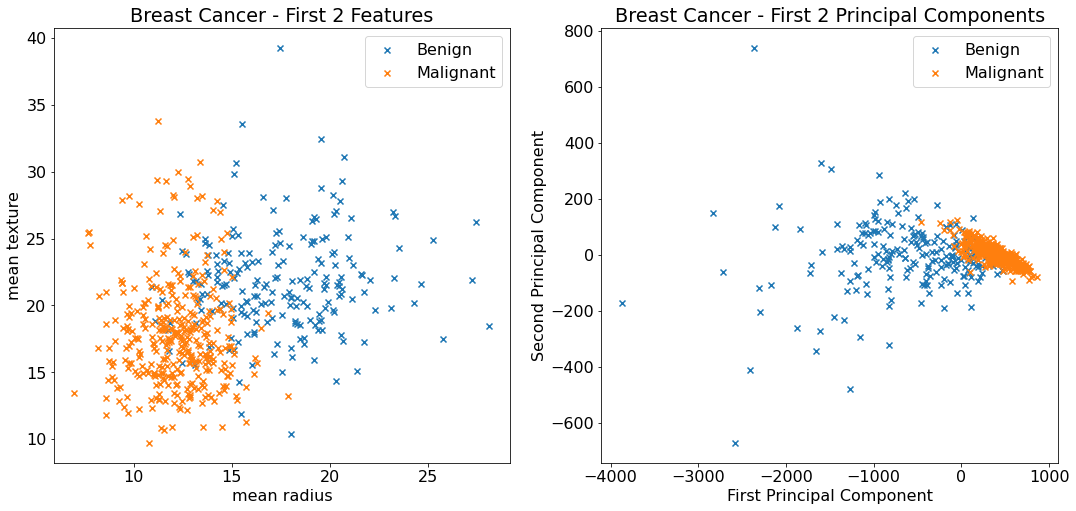

In [5]:
# plot first 2 components against first 2 features
X2 = X_centred @ V[:, :2]

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# first 2 features
ax = axs[0]
ax.scatter(X[y == 0, 0], X[y == 0, 1], marker="x", label="Benign")
ax.scatter(X[y == 1, 0], X[y == 1, 1], marker="x", label="Malignant")

ax.set_xlabel(feat_names[0])
ax.set_ylabel(feat_names[1])

ax.set_title("Breast Cancer - First 2 Features")

ax.legend()

# first 2 pcs
ax = axs[1]
ax.scatter(X2[y == 0, 0], X2[y == 0, 1], marker="x", label="Benign")
ax.scatter(X2[y == 1, 0], X2[y == 1, 1], marker="x", label="Malignant")

ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

ax.set_title("Breast Cancer - First 2 Principal Components")

ax.legend();

**Using Scikit-Learn**
- `decomposition.PCA(n_components=d)` uses SVD decomposition to implement PCA and project to the first $d$ principal components
- The `components_` attribute holds $\mathbf{W}_d^T$

In [6]:
# pca using sklearn
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

print("First 2 principal components: ", pca.components_)

First 2 principal components:  [[ 5.08623202e-03  2.19657026e-03  3.50763298e-02  5.16826469e-01
   4.23694535e-06  4.05260047e-05  8.19399539e-05  4.77807775e-05
   7.07804332e-06 -2.62155251e-06  3.13742507e-04 -6.50984008e-05
   2.23634150e-03  5.57271669e-02 -8.05646029e-07  5.51918197e-06
   8.87094462e-06  3.27915009e-06 -1.24101836e-06 -8.54530832e-08
   7.15473257e-03  3.06736622e-03  4.94576447e-02  8.52063392e-01
   6.42005481e-06  1.01275937e-04  1.68928625e-04  7.36658178e-05
   1.78986262e-05  1.61356159e-06]
 [ 9.28705650e-03 -2.88160658e-03  6.27480827e-02  8.51823720e-01
  -1.48194356e-05 -2.68862249e-06  7.51419574e-05  4.63501038e-05
  -2.52430431e-05 -1.61197148e-05 -5.38692831e-05  3.48370414e-04
   8.19640791e-04  7.51112451e-03  1.49438131e-06  1.27357957e-05
   2.86921009e-05  9.36007477e-06  1.22647432e-05  2.89683790e-07
  -5.68673345e-04 -1.32152605e-02 -1.85961117e-04 -5.19742358e-01
  -7.68565692e-05 -2.56104144e-04 -1.75471479e-04 -3.05051743e-05
  -1.57042

**Explained Variance Ratio**
- The *explained variance ratio* of one of the principal components is the proportion of the dataset's variance that lies along that component *(I'm not sure what this means precisely)*
- It can be accessed as the `explained_variance_ratio_` of PCA

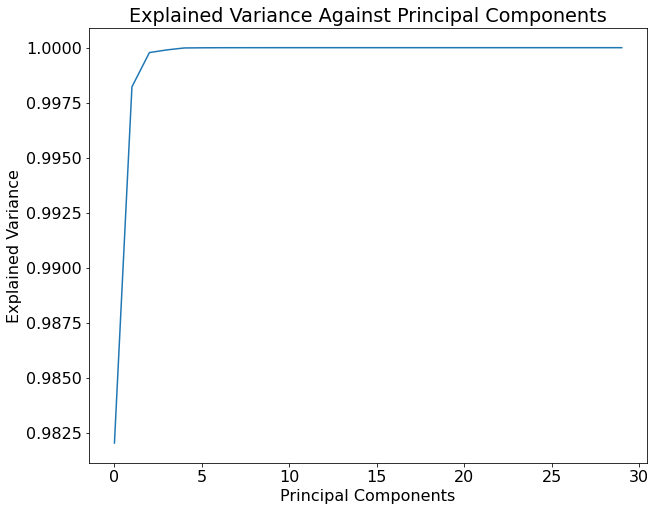

In [7]:
# explained variance against number of principal components
pca = PCA()
pca.fit(X)

fig, ax = plt.subplots()

cumsum = pca.explained_variance_ratio_.cumsum()
ax.plot(cumsum)

ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance")

ax.set_title("Explained Variance Against Principal Components");

So essentially all variance is explained by the first 3 features.

**Choosing the Right Number of Dimensions**
- One way to choose $d$ is find the smallest value that explains a given proportion of the variance
- You can do this by intialised `PCA(n_components=0.95)`
- You can also plot the (cumulative) explained variance against $d$ and find the 'elbow' where the growth starts slowing down

In [8]:
# how many components required to explain 99% of variance?
pca = PCA(n_components=0.99)
pca.fit(X)

pca.n_components_

2

**PCA for Compression**
- Dimesionality reduction will also reduce file sizes
- Applying the inverse transformation `inverse_transform` will give a approximation to the original data
- *Reconstruction error: *the mean squared distance between the original data and the reconstructed data
- The inverse transformation is $\mathbf{X}_{\text{recovered}} = \mathbf{X}_d\mathbf{W}_d^T$

In [9]:
pca = PCA(n_components=2)
X_red = pca.fit_transform(X)
X_rec = pca.inverse_transform(X2)

print("Original dataset: {} bytes".format(getsizeof(X)))
print("Reduced dataset: {} bytes".format(getsizeof(X_red)))
print("Recovered dataset: {} bytes".format(getsizeof(X_rec)))

Original dataset: 136680 bytes
Reduced dataset: 120 bytes
Recovered dataset: 136680 bytes


**Randomized PCA:** a stochastic algorithm that quickly finds an approximation to the first $d$ principal components
- Computational complexity is $O(m\times d^2) + O(d^3)$ instead of $O(m\times n^2) + O(n^3)$ for the full SVD
- You can apply this in Scikit-Learn using `svd_solver="randomized"`
- By default Scikit-Learn uses randomized if $d<0.8 * m$ and full otherwise

In [10]:
# randomised pca
rnd_pca = PCA(n_components=10, svd_solver="randomized")

**Incremental PCA:** allows you train PCA by feeding in the training one mini-batch at a time
- This doesn't require the whole training set to fit in memory
- Useful for large training sets and for applying PCA online
- Scikit-Learn's `IncrementalPCA` implements this - you must call `partial_fit` on each mini-batch
- Alternatively, `np.memmap` allows you to manipulate a large array as if it were in memory, loading only the data it needs in memory. Since `IncrementalPCA` only uses a small part at a time, you can just call `fit` on the memmap object

In [11]:
# train pca in mini batches
n_batch = 12
inc_pca = IncrementalPCA(n_components=10)
for X_batch in np.array_split(X, n_batch):
    inc_pca.partial_fit(X_batch)


inc_pca.transform(X)

array([[ 1.16014257e+03, -2.93917544e+02,  4.85783976e+01, ...,
         1.48104767e-01, -7.43794567e-01,  6.19374673e-01],
       [ 1.26912244e+03,  1.56301818e+01, -3.53945342e+01, ...,
         2.00629531e-01,  4.85564321e-01, -9.28320607e-02],
       [ 9.95793889e+02,  3.91567432e+01, -1.70975298e+00, ...,
        -2.75189265e-01,  1.73388273e-01, -2.15243093e-01],
       ...,
       [ 3.14501756e+02,  4.75535252e+01, -1.04424072e+01, ...,
        -4.41087633e-01,  9.70773033e-02, -1.34648150e-01],
       [ 1.12485812e+03,  3.41292250e+01, -1.97420874e+01, ...,
        -3.63997219e-01, -3.83163941e-01,  5.81755534e-01],
       [-7.71527622e+02, -8.86431064e+01,  2.38890319e+01, ...,
         3.02414933e-02,  4.22573930e-01, -3.13981148e-01]])

In [12]:
# save breast cancer data - must be saved as binary file
np.save(datasets_path(BREAST_CANCER_INPUTS), X)

# load in memmap
X_mm = np.memmap(
    datasets_path(BREAST_CANCER_INPUTS),
    dtype="float64",
    mode="readonly",
    shape=(n_sample, n_feat),
)

batch_size = n_sample // n_batch
inc_pca = IncrementalPCA(n_components=5, batch_size=batch_size)

# fitting doesn't work for some reason
# inc_pca.fit(X_mm)

## Kernel PCA

- Kernel PCA works using the kernel trick - it effectively performs PCA in the (possibly infinite dimensional) feature space
- This is good at preserving clusters of instances after projection, or sometimes unrolling datasets that lie close to a twisted manifold

In [13]:
def plot_first_two_features(X, y, ax=None, title=None):
    if not ax:
        fig, ax = plt.subplots()

    ax.scatter(X[y == 0, 0], X[y == 0, 1], marker="x", label="Benign")
    ax.scatter(X[y == 1, 0], X[y == 1, 1], marker="x", label="Malignant")

    if not title:
        title = "Breast Cancer - First 2 Features"

    ax.set_title(title)

    ax.legend()

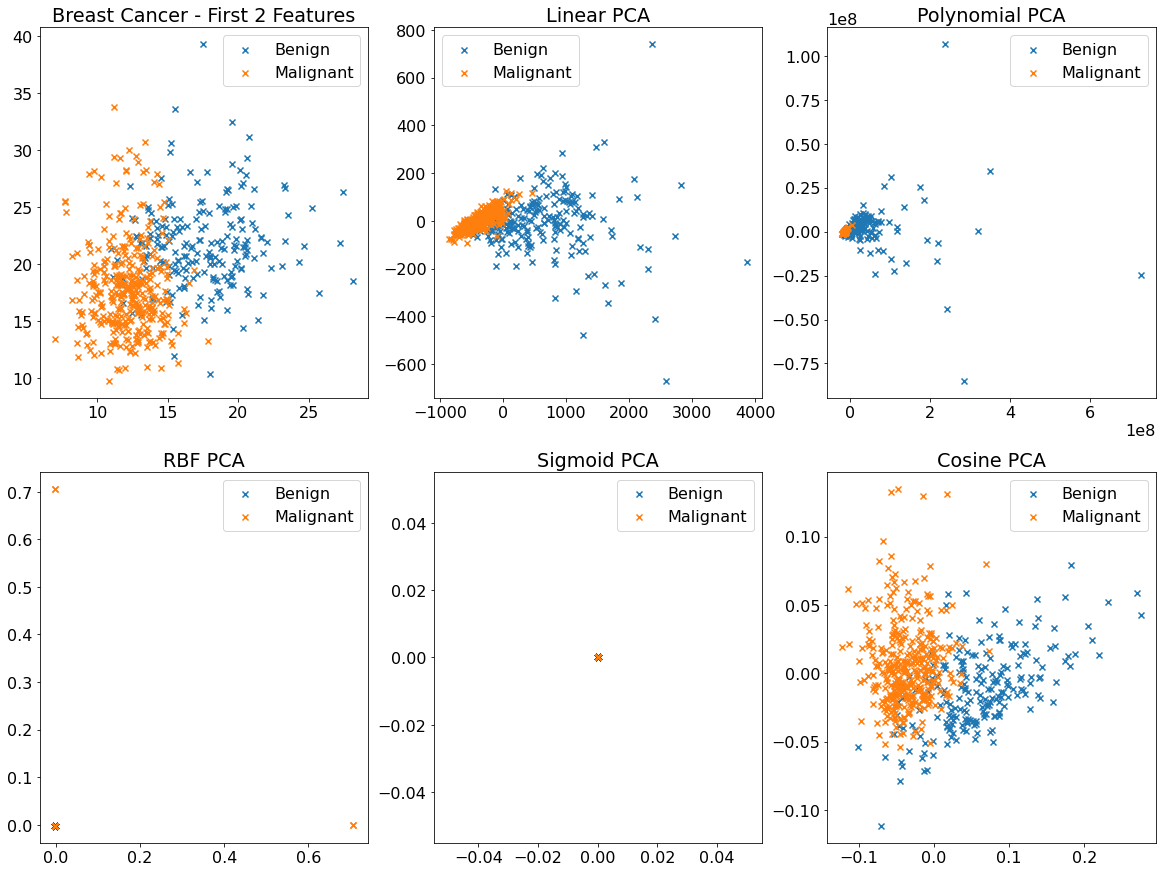

In [14]:
lin_pca = KernelPCA(n_components=2, kernel="linear")
X_lin = lin_pca.fit_transform(X)

poly_pca = KernelPCA(n_components=2, kernel="poly", degree=3)
X_poly = poly_pca.fit_transform(X)

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=1)
X_rbf = rbf_pca.fit_transform(X)

sig_pca = KernelPCA(n_components=2, kernel="sigmoid")
X_sig = sig_pca.fit_transform(X)

cos_pca = KernelPCA(n_components=2, kernel="cosine")
X_cos = cos_pca.fit_transform(X)

fig, axs = plt.subplots(2, 3, figsize=(20, 15))

axs_ravel = axs.ravel()

plot_first_two_features(X, y, ax=axs_ravel[0])
plot_first_two_features(X_lin, y, ax=axs_ravel[1], title="Linear PCA")
plot_first_two_features(X_poly, y, ax=axs_ravel[2], title="Polynomial PCA")
plot_first_two_features(X_rbf, y, ax=axs_ravel[3], title="RBF PCA")
plot_first_two_features(X_sig, y, ax=axs_ravel[4], title="Sigmoid PCA")
plot_first_two_features(X_cos, y, ax=axs_ravel[5], title="Cosine PCA")

Different values of hyperparameters make a big difference

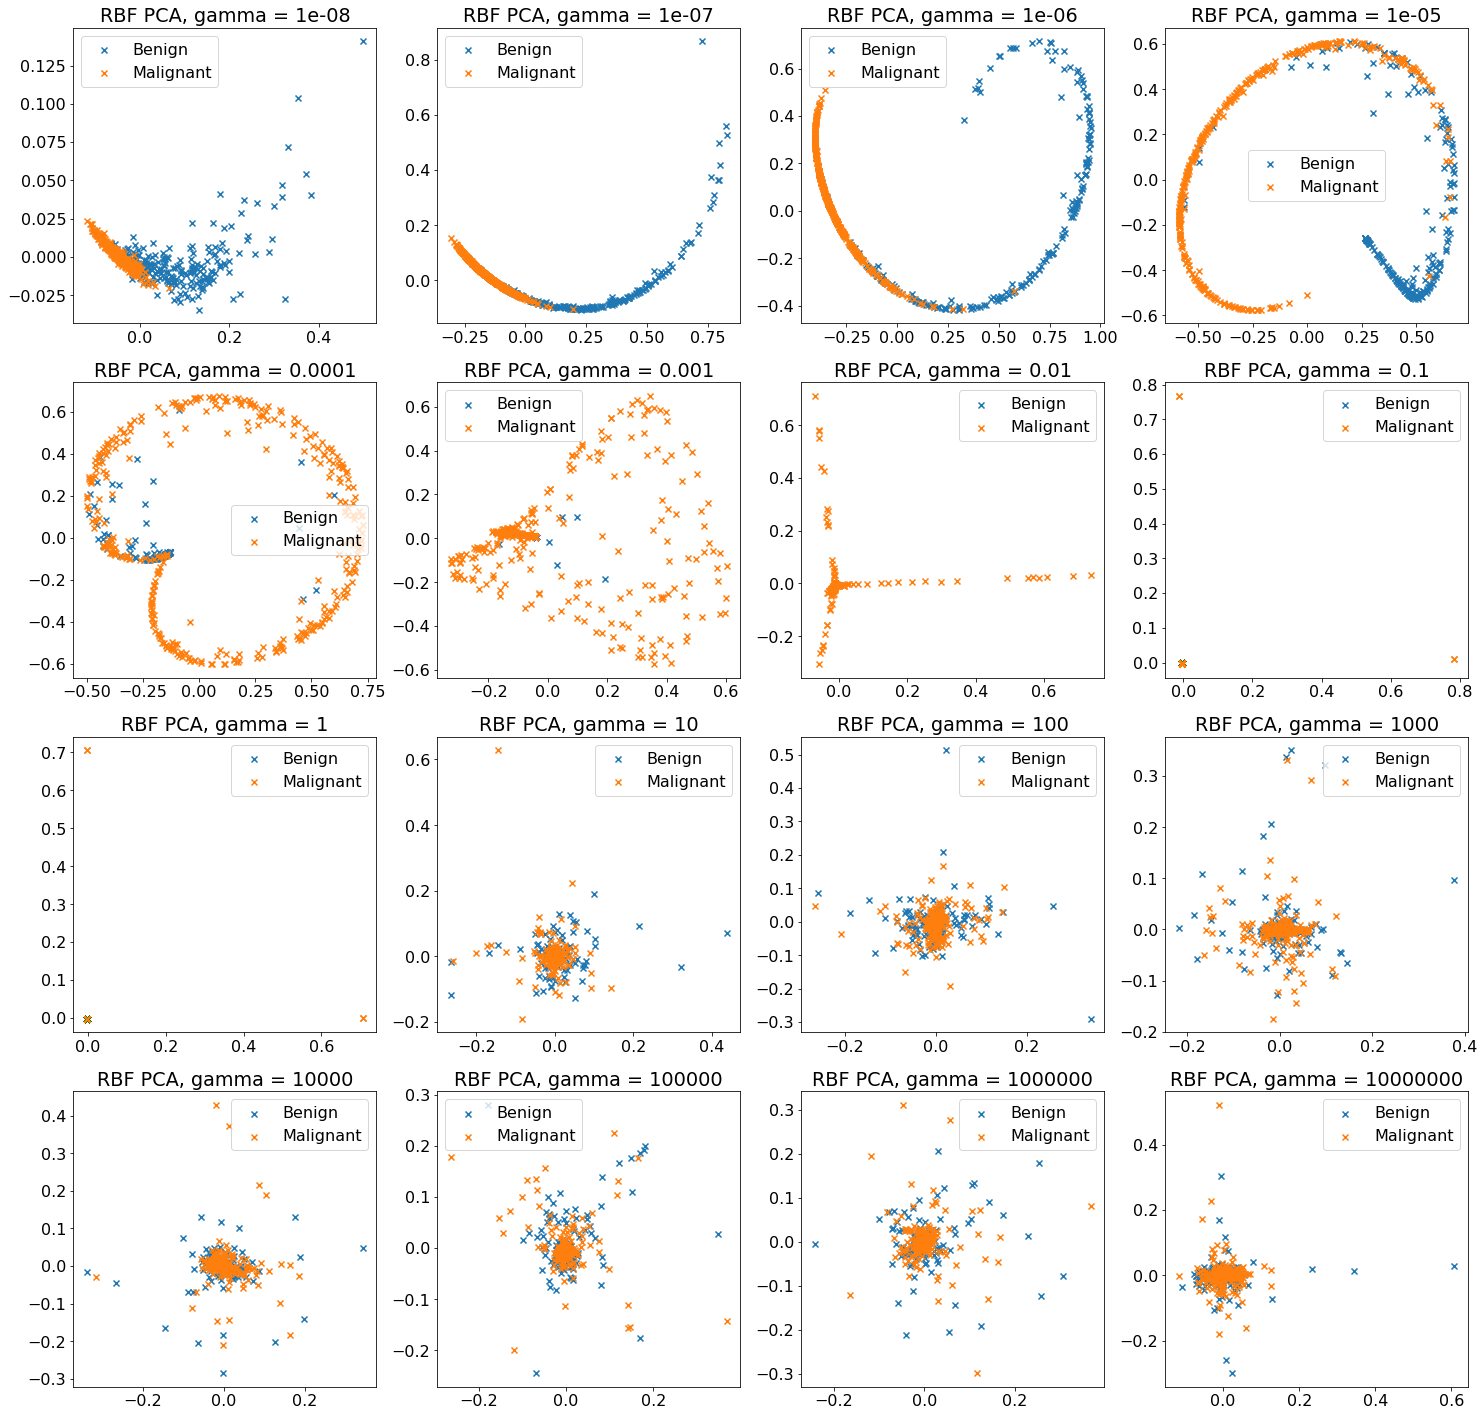

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(25, 25))
axs_ravel = axs.ravel()

gamma_list = [10**i for i in range(-8, 8)]
for i, gamma in enumerate(gamma_list):
    rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=gamma)
    X_rbf = rbf_pca.fit_transform(X)

    plot_first_two_features(
        X_rbf, y, ax=axs_ravel[i], title="RBF PCA, gamma = {}".format(gamma)
    )

**Selecting a Kernel and Tuning Hyperparameters**
- KPCA is unsupervised so there is no obvious performance measure to help you select the best kernel or hyperparameter values
- If the KPCA is part of a pipeline for a task then you can select the kernel and hyperparameters based on downstream metrics
- Another approach is to minimise reconstruction error, *but* with KPCA you can't directly reverse the transformation (atleast without knowing the feature map $\phi$)
- It is possible to find a *reconstruction pre-image* - a point in the original space that would map close to the reconstructed point - by training a supervised regression model
- Scikit-Learn will do this if you enable `fit_inverse_transform=True`

### Selecting Hyperparameters: Downstream Accuracy

In [16]:
# pipeline of kpca and logistic regression - grid search for best kernel and hyperparams
pipe = Pipeline(
    [("kpca", KernelPCA(n_components=2)), ("log_reg", LogisticRegression())]
)

gamma_list = [10**i for i in range(-8, 4)]
param_grid = [
    {"kpca__kernel": ["linear", "poly", "sigmoid", "cosine"]},
    {"kpca__kernel": ["rbf"], "kpca__gamma": gamma_list},
]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    scoring="accuracy",
    cv=3,
    return_train_score=True,
    refit=False,
)


def get_cv_summary(grid_search):
    cv_results = grid_search.cv_results_

    cv_summary = pd.DataFrame(cv_results["params"])
    cv_summary["mean_train_score"] = cv_results["mean_train_score"].round(3)
    cv_summary["mean_test_score"] = cv_results["mean_test_score"].round(3)
    cv_summary = cv_summary.sort_values(
        by="mean_test_score", ascending=False
    ).reset_index(drop=True)

    return cv_summary


grid_search.fit(X, y)
cv_summary = get_cv_summary(grid_search)
cv_summary

,kpca__kernel,kpca__gamma,mean_train_score,mean_test_score
0,linear,NaN,0.930,0.924
1,rbf,1.000000e-06,0.910,0.900
2,rbf,1.000000e-07,0.891,0.886
3,rbf,1.000000e-05,0.900,0.886
4,poly,NaN,0.850,0.842
5,rbf,1.000000e-08,0.813,0.814
6,cosine,NaN,0.752,0.745
7,sigmoid,NaN,0.627,0.627
8,rbf,1.000000e-03,0.627,0.627
9,rbf,1.000000e-02,0.627,0.627


I want to plot some of the top performers' decision boundaries.

In [17]:
def plot_decision_boundary(clf, X_pc, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    def solve_linear_equation(intercept, coef, x0):
        "solve intercept + coef[0]*x0 + coef[1]*x1 = 0"
        x1 = -intercept - coef[0] * x0
        x1 /= coef[1]

        return x1

    x0 = np.linspace(X_pc[:, 0].min(), X_pc[:, 0].max())
    x1 = solve_linear_equation(clf.intercept_[0], clf.coef_[0], x0)

    ax.plot(x0, x1, ls="--", color="k", label="Decision Boundary")


def plot_kpca_classifier(pipe, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    X_pc = pipe["kpca"].transform(X)

    plot_first_two_features(X_pc, y, ax=ax)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    plot_decision_boundary(pipe["log_reg"], X_pc, ax=ax)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_title(
        "Kernel = {}, gamma = {}".format(
            pipe.get_params()["kpca__kernel"], pipe.get_params()["kpca__gamma"]
        )
    )

    ax.legend()

Fit the top performing KPCA parameters to the data and plot decision boundaries.

Remember that the logistic regression also has important hyperparameters. For each set of KPCA parameters, we perform a coarse grid search over the regularisation hyperparameter `C` for the logistic regression and print the best and worst values with their test scores. The decision boundaries we plot use the best values for `C`.

KPCA params: kernel = linear, gamma = None
Grid search worse params: C = 0.001
Grid search worse test accuracy: 0.924
Grid search best params: C = 0.001
Grid search best test accuracy: 0.924

KPCA params: kernel = cosine, gamma = None
Grid search worse params: C = 0.001
Grid search worse test accuracy: 0.627
Grid search best params: C = 10000
Grid search best test accuracy: 0.916

KPCA params: kernel = rbf, gamma = 1e-08
Grid search worse params: C = 0.001
Grid search worse test accuracy: 0.627
Grid search best params: C = 100000
Grid search best test accuracy: 0.924

KPCA params: kernel = rbf, gamma = 1e-07
Grid search worse params: C = 0.001
Grid search worse test accuracy: 0.627
Grid search best params: C = 10
Grid search best test accuracy: 0.900

KPCA params: kernel = rbf, gamma = 1e-06
Grid search worse params: C = 0.001
Grid search worse test accuracy: 0.627
Grid search best params: C = 1
Grid search best test accuracy: 0.900

KPCA params: kernel = rbf, gamma = 1e-05
Grid search

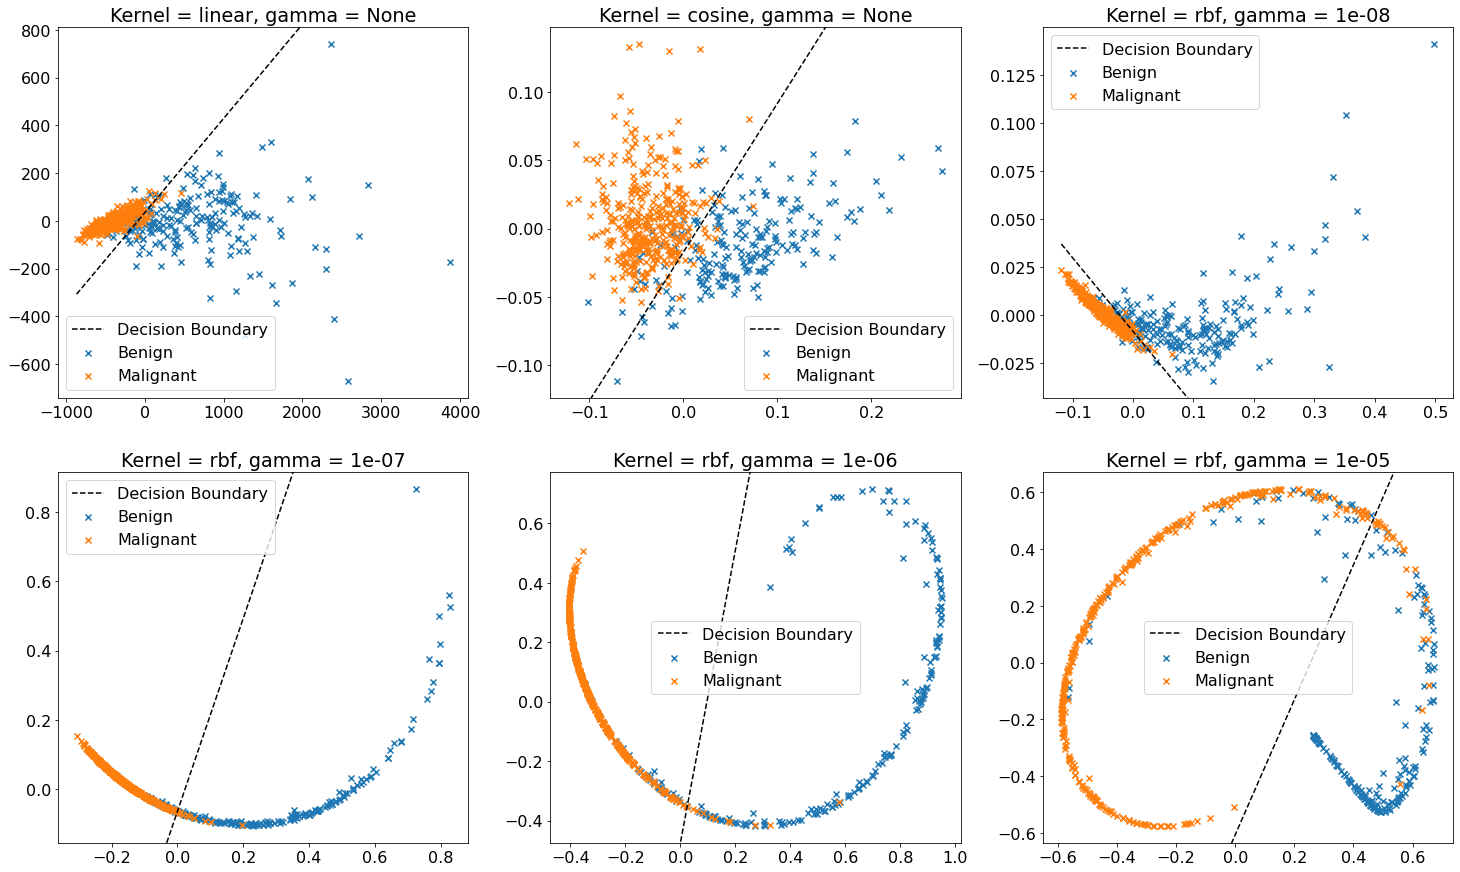

In [18]:
kpca_param_grid = [
    {"kpca__kernel": "linear", "kpca__gamma": None},
    {"kpca__kernel": "cosine", "kpca__gamma": None},
    {"kpca__kernel": "rbf", "kpca__gamma": 1e-8},
    {"kpca__kernel": "rbf", "kpca__gamma": 1e-7},
    {"kpca__kernel": "rbf", "kpca__gamma": 1e-6},
    {"kpca__kernel": "rbf", "kpca__gamma": 1e-5},
]
log_reg_param_grid = {
    "log_reg__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
}

fig, axs = plt.subplots(2, 3, figsize=(25, 15))
axs_ravel = axs.ravel()

for i, kpca_params in enumerate(kpca_param_grid):
    pipe.set_params(**kpca_params)

    grid_search = GridSearchCV(
        pipe,
        param_grid=log_reg_param_grid,
        scoring="accuracy",
        cv=3,
        refit=True,
    )
    grid_search.fit(X, y)

    mean_test_scores = grid_search.cv_results_["mean_test_score"]

    print(
        "KPCA params: kernel = {}, gamma = {}".format(
            kpca_params["kpca__kernel"], kpca_params["kpca__gamma"]
        )
    )

    print(
        "Grid search worse params: C = {}".format(
            log_reg_param_grid["log_reg__C"][np.argmin(mean_test_scores)]
        )
    )
    print("Grid search worse test accuracy: {:.3f}".format(mean_test_scores.min()))

    print(
        "Grid search best params: C = {}".format(
            log_reg_param_grid["log_reg__C"][np.argmax(mean_test_scores)]
        )
    )
    print("Grid search best test accuracy: {:.3f}".format(mean_test_scores.max()))
    print("")

    plot_kpca_classifier(grid_search.best_estimator_, axs_ravel[i])

Notice that optimising `C` made a big difference to performance.

### Selecting Hyperparameters: Reconstruction Error

In [24]:
kpca = KernelPCA(n_components=2, fit_inverse_transform=True)

param_list = [
    {"kernel": "linear", "gamma": None},
    {"kernel": "cosine", "gamma": None},
    {"kernel": "rbf", "gamma": 1e-8},
    {"kernel": "rbf", "gamma": 1e-7},
    {"kernel": "rbf", "gamma": 1e-6},
    {"kernel": "rbf", "gamma": 1e-5},
]

for params in param_list:
    kpca.set_params(**params)
    X_red = kpca.fit_transform(X)
    X_pre = kpca.inverse_transform(X_red)

    recon_err = mean_squared_error(X, X_pre)
    print(
        "KPCA params: kernel = {}, gamma = {}".format(params["kernel"], params["gamma"])
    )
    print("Reconstruction error: {}".format(recon_err))
    print("")

KPCA params: kernel = linear, gamma = None
Reconstruction error: 4.557929539989507e-12

KPCA params: kernel = cosine, gamma = None
Reconstruction error: 3.172746345570245e-23

KPCA params: kernel = rbf, gamma = 1e-08
Reconstruction error: 4.937960293780784e-24

KPCA params: kernel = rbf, gamma = 1e-07
Reconstruction error: 4.341739709496908e-24

KPCA params: kernel = rbf, gamma = 1e-06
Reconstruction error: 4.637004276136205e-24

KPCA params: kernel = rbf, gamma = 1e-05
Reconstruction error: 4.720997231849292e-24



Interestingly, though a linear kernel gives the best downstream accuracy, it has the largest reconstruction error.

## LLE

- *Locally Linear Embedding (LLE):* a non-linear dimensionality reduction technique and an example of manifold learning
- LLE measures how training instances linearly relate to their nearest neighbours and looks for a low-dimensional represention of the training set that preserves these local relationships
- It works best at unrolling twisted manifolds, particularly where there is low noise
- *Note:* since this works based on distances between instances, it's best to scale the training data first
- For each training instance $\mathbf{x}^{(i)}$, find the $k$ nearest neighbours, and find weights $w_{i,j}$ to minimise the square distance between $\mathbf{x}^{(i)}$ and $\sum_j w_{i,j}\mathbf{x}^{(i)}$, with $w_{i,j}=0$ if $\mathbf{x}^{(j)}$ is not one of the nearest neighbours and normalisation $\sum_j w_{i,j}=1$
- This is a constrained optimisation problem that results in a $m\times m$ matrix $\hat{\mathbf{W}}$
- Next we search for $d$-dimensional vectors $\mathbf{z}^{(i)}$ that minimise the squared distance between $\mathbf{z}^{(i)}$ and $\sum_j \hat{w}_{i,j}\mathbf{z}^{(j)}$
- This is an unconstrained optimisation problem that leads to a mapping $\mathbf{x}^{(i)}\mapsto \mathbf{z}^{(i)}$
- Computational complexity:
    - Finding KNN: $O(nm\ln(m)\ln(k))$
    - Optimising weights: $O(mnk^3)$
    - Constructing low-dimensional representations: $O(dm^2)$
- The $m^2$ and $k^3$ mean that this doesn't scale very well with $m$ and $k$

n_neighbors = 5
Reconstruction error: 0.001197674776764393

n_neighbors = 10
Reconstruction error: 1.0633986575287168e-05

n_neighbors = 20
Reconstruction error: 6.274582955284154e-07

n_neighbors = 50
Reconstruction error: 2.4768098977448447e-05

n_neighbors = 100
Reconstruction error: 5.1903603544608396e-05

n_neighbors = 200
Reconstruction error: 0.00010121367367424052



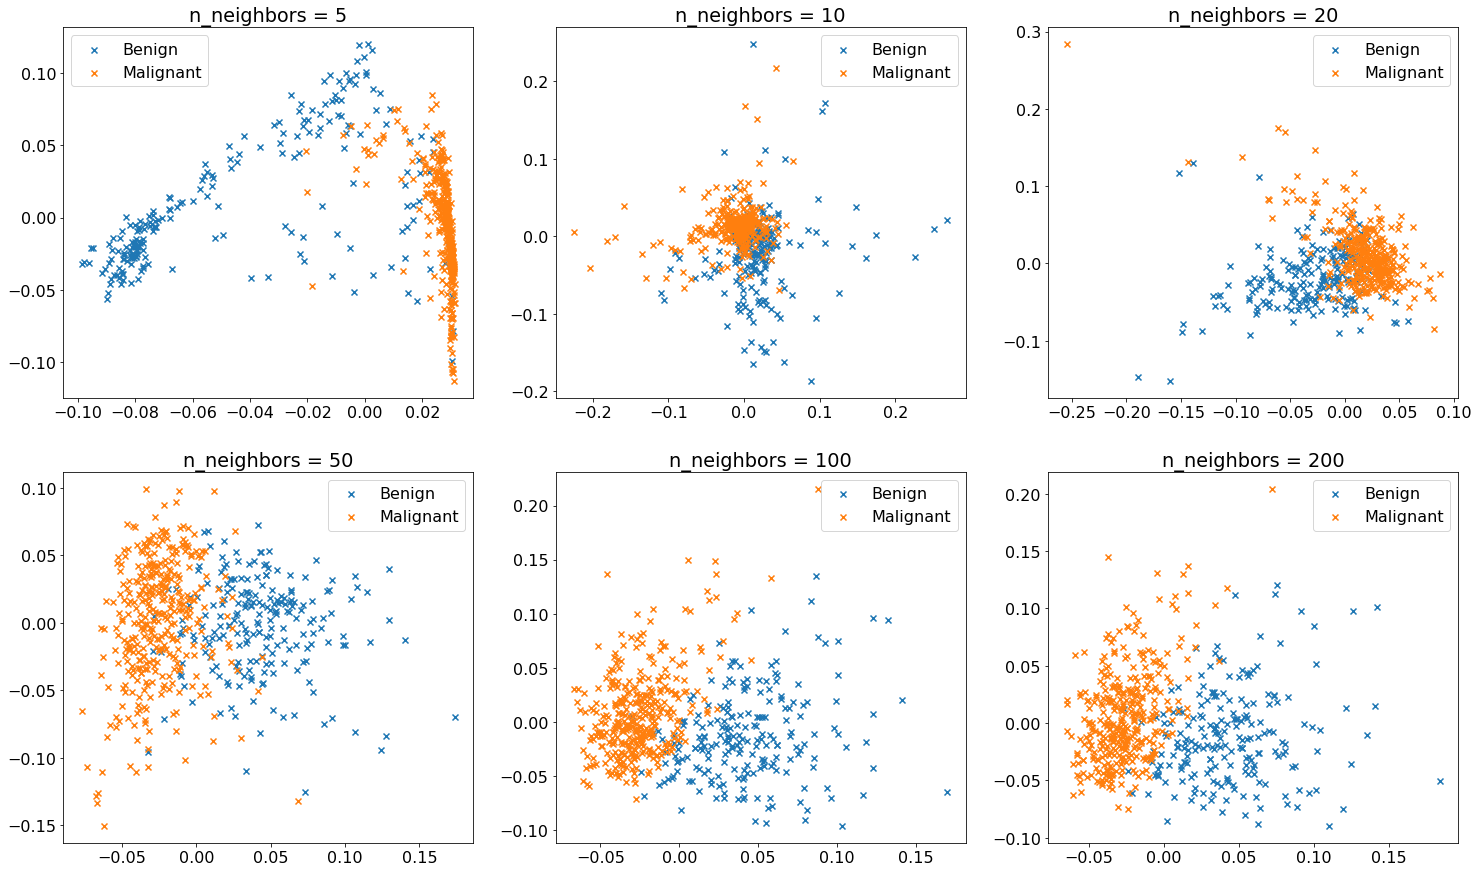

In [44]:
lle = LocallyLinearEmbedding(n_components=2)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

fig, axs = plt.subplots(2, 3, figsize=(25, 15))
axs_ravel = axs.ravel()

n_neighbors_list = [5, 10, 20, 50, 100, 200]
for i, n_neighbors in enumerate(n_neighbors_list):
    lle.set_params(n_neighbors=n_neighbors)
    X_lle = lle.fit_transform(X_scaled)

    title = "n_neighbors = " + str(n_neighbors)

    print(title)
    print("Reconstruction error: {}".format(lle.reconstruction_error_))
    print("")

    plot_first_two_features(X_lle, y, ax=axs_ravel[i], title=title)

It seems empirically true that greater values of `n_neighbors` lead to greater reconstruction error

## Other Dimensionality Reduction Techniques

- *Random Projections*
    - Projects the data to a lower-dimensional space using a random linear projection
    - Is mathematically very likely to preserve distances well
    - Quality of dimennsionality reduction depends on size of training set and target dimensionality, but *not* initial dimensionality
- *Multidimensional Scaling (MDS):* reduces dimensionality which trying to preserve distances between the instances
- *Isomap:* creates a graph connecting each instance to its nearest neighbours, then reduces dimensionality which try to preserve geodesic distances
- *t-Distributed Stochastic Neighbour Embedding (t-SNE)*
    - Reduces dimensionality which trying to keep similar instances close and dissimilar instances apart
    - Most used for visualisation, particularly for clusters of instances in high-dimensional space (e.g. visualising MNIST images in 2d)
- *Linear Discriminant Analysis (LDA)*
    - A classification algorithm that learns the most discriminative axes between the clsses - you can then project onto these
    - Projection will keep classes faar apart so LDA is effective for reducing dimensionality before running another classification algorithm such as SVC